# Getting Started with AutoARIMA and ETS

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/Getting_Started_with_Auto_Arima_and_ETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Automatic forecasting tools tackle the needs for predictions over large collections of univariate time series that often arise in business practice and other contexts. Among these solutions, R's forecasting package `auto.arima` and `ets` has been a reference for their accuracy and high quality for many years.

Unfortunately, baselines with their accuracy and computational efficiency were not available for Python yet. For this reason, we developed our new and highly efficient pure-Python implementation of these classic algorithms that we showcase in this notebook.


If you are interested in talking about this or other time series models or want to sclae your models in production environments don't hesitate to send us an email at hello[at]nixtla.io or join our [slack community](https://join.slack.com/t/nixtlacommunity/shared_invite/zt-135dssye9-fWTzMpv2WBthq8NK0Yvu6A).

[Hyndman, RJ and Khandakar, Y (2008) "Automatic time series forecasting: The forecast package for R", Journal of Statistical Software, 26(3).](https://www.jstatsoft.org/article/view/v027i03)

## Installing StatsForecast Library

In [ ]:
%%capture
!pip install -U numba
!pip install -U statsmodels
!pip install statsforecast

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ETS
from statsforecast.utils import AirPassengersDF

If you want to list all avaiaible models run the following lines,

In [ ]:
#from statsforecast.models import __all__
#__all__

## Loading AirPassengers Example Data

In [ ]:
# We define the train df. 
# We use the index functionality to make the training a lot faster.
Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


## Fit AutoArima and AutoETS

**ETS:** The exponential smoothing (ETS) algorithm is especially suited for data with seasonality and trend. ETS computes a weighted average over all observations in the input time series dataset as its prediction. In contrast to moving average methods with constant weights, ETS weights exponentially decrease over time, capturing long term dependencies while prioritizing new observations.

**AutoARIMA:** The autoregressive integrated moving average (ARIMA), combines differencing steps, lag regression and moving averages into a single method capable of modeling non-stationary time series. This method complements on ETS and it is based on the description of data's autocorrelations.

In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

Define the parameters that you want to use in your models. For `ETS` we pass a `ZMZ`, model, which stands for error and trend kinds selected optimally. In this step, you could include further models like: `SeasonalExponentialSmoothing`, `ADIDA`, `HistoricAverage`, `CrostonClassic`, `CrostonSBA`, `CrostonOptimized`, `SeasonalWindowAverage`, `SeasonalNaive`, `IMAPA`, `Naive`, `RandomWalkWithDrift`, `WindowAverage`, `SeasonalExponentialSmoothing`, and `TSB`.

In [ ]:
season_length = 12
horizon = len(Y_test_df)
models = [
    AutoARIMA(season_length=season_length),
    ETS(season_length=season_length, model='ZMZ')
]
model = StatsForecast(
    df=Y_train_df, 
    models=models,
    freq='M', 
    n_jobs=-1,
)

Y_hat_df = model.forecast(horizon).reset_index()
Y_hat_df.head()

,unique_id,ds,AutoARIMA,ETS
0,1.0,1960-01-31,424.160156,419.163574
1,1.0,1960-02-29,407.081696,416.904449
2,1.0,1960-03-31,470.860535,480.243378
3,1.0,1960-04-30,460.913605,461.996887
4,1.0,1960-05-31,484.900879,463.853241


## Plot and Evaluate Predictions

We are going to plot the models againts the real values of test.

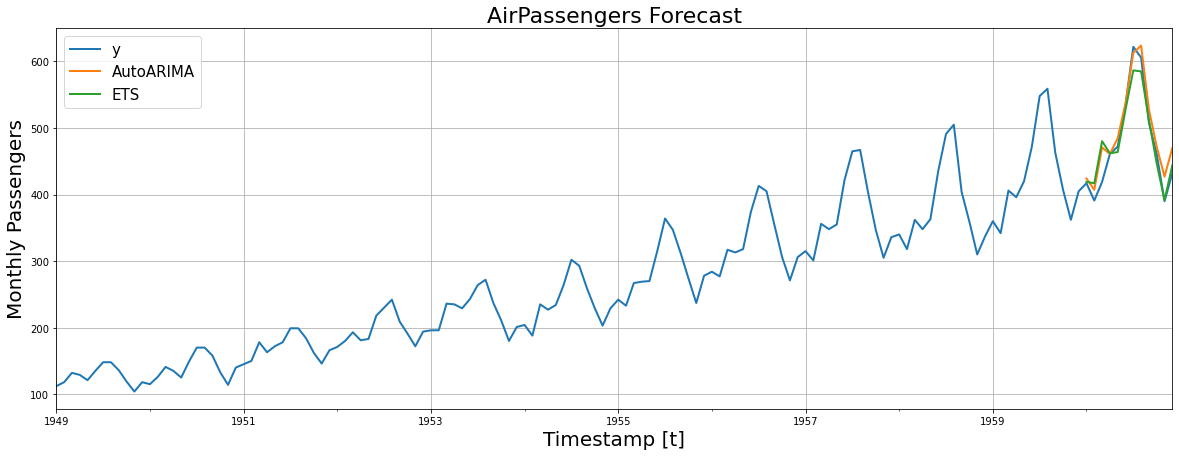

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'AutoARIMA', 'ETS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Finally, we evaluate the predictions accuracy using the Mean Absolute Error:

$$
\qquad MAE = \frac{1}{Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}|\qquad
$$

In [ ]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
ets_preds = Y_hat_df['ETS'].values
arima_preds = Y_hat_df['AutoARIMA'].values

print('ETS   MAE: %0.3f' % mae(ets_preds, y_true))
print('ARIMA MAE: %0.3f' % mae(arima_preds, y_true))

ETS   MAE: 16.222
ARIMA MAE: 18.551


## Add Confidence Intervals to ARIMA

You just need to add the `level` argument to the `StatsForecast.forecast` method as follows,

In [ ]:
Y_hat_df_intervals = model.forecast(h=12, level=(80, 95))

Then we plot the intervals,

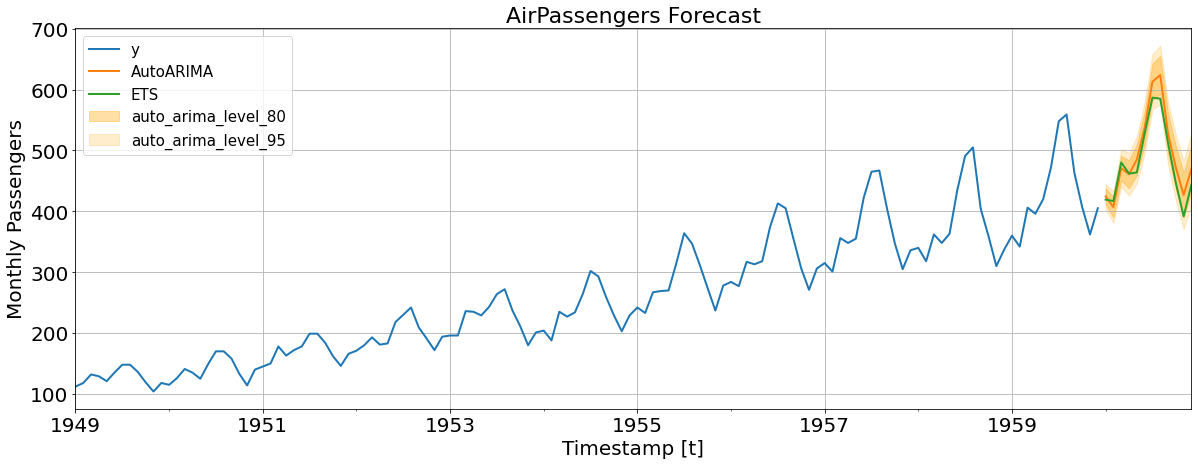

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([Y_train_df, Y_hat_df_intervals]).set_index('ds')
df_plot[['y', 'AutoARIMA','ETS']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-80'], 
                df_plot['AutoARIMA-hi-80'],
                alpha=.35,
                color='orange',
                label='auto_arima_level_80')
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-95'], 
                df_plot['AutoARIMA-hi-95'],
                alpha=.2,
                color='orange',
                label='auto_arima_level_95')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

## Add external regressors to ARIMA

First we are going to include new exogenous variables as columns to our train data frame. (You can include things like weather or holidays.)

In [ ]:
%%capture
Y_train_df['trend'] = np.arange(1, len(Y_train_df) + 1)
Y_train_df['intercept'] = np.ones(len(Y_train_df))
Y_train_df['month'] = Y_train_df['ds'].dt.month
Y_train_df = pd.get_dummies(Y_train_df, columns=['month'], drop_first=True)

In [ ]:
Y_train_df.head()

,unique_id,ds,y,trend,intercept,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1.0,1949-01-31,112.0,1,1.0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,1949-02-28,118.0,2,1.0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,1949-03-31,132.0,3,1.0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,1949-04-30,129.0,4,1.0,0,0,1,0,0,0,0,0,0,0,0
4,1.0,1949-05-31,121.0,5,1.0,0,0,0,1,0,0,0,0,0,0,0


We consruct the test dataframe of exogenous variables.

In [ ]:
# 
xreg_test = pd.DataFrame({
  'unique_id': 1,
  'ds': pd.date_range(start='1960-01-01', periods=len(Y_hat_df), freq='M')
})
# We construct xreg for test. The train series ends at the 133th step. 
xreg_test['trend'] = np.arange(133, len(Y_hat_df) + 133)
xreg_test['intercept'] = np.ones(len(Y_hat_df))
xreg_test['month'] = xreg_test['ds'].dt.month
xreg_test = pd.get_dummies(xreg_test, columns=['month'], drop_first=True)
xreg_test.head()

,unique_id,ds,trend,intercept,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1960-01-31,133,1.0,0,0,0,0,0,0,0,0,0,0,0
1,1,1960-02-29,134,1.0,1,0,0,0,0,0,0,0,0,0,0
2,1,1960-03-31,135,1.0,0,1,0,0,0,0,0,0,0,0,0
3,1,1960-04-30,136,1.0,0,0,1,0,0,0,0,0,0,0,0
4,1,1960-05-31,137,1.0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
season_length = 12
model = StatsForecast(
    df=Y_train_df, 
    models=models, 
    freq='M', 
    n_jobs=-1
)

Y_hat_df_xreg = model.forecast(horizon, X=xreg_test)
Y_hat_df_xreg = Y_hat_df_xreg.reset_index()

We are going to plot the models againts the real values of test.

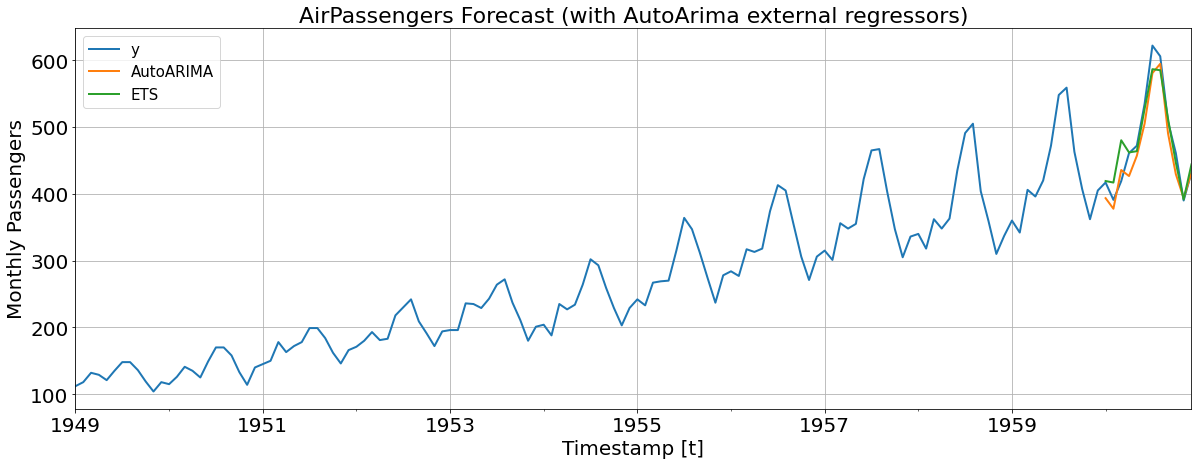

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df_xreg = Y_test_df.merge(Y_hat_df_xreg, how='left', on=['unique_id', 'ds'])
df_plot = pd.concat([Y_train_df, Y_hat_df_xreg]).set_index('ds')
df_plot[['y', 'AutoARIMA','ETS']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast (with AutoArima external regressors)', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

## Include other Benchmark models

We import more benchmark models as follows,

In [ ]:
from statsforecast.models import SeasonalNaive, Naive

In [ ]:
season_length = 12
models = [
    AutoARIMA(season_length=12),
    ETS(season_length=12),
    SeasonalNaive(season_length=12),
    Naive()
]
model = StatsForecast(
    df=Y_train_df, 
    models=models, 
    freq='M', 
    n_jobs=-1
)

Y_hat_df_bench = model.forecast(horizon, X=xreg_test)
Y_hat_df_bench = Y_hat_df_bench.reset_index()

We are going to plot the models againts the real values of test,

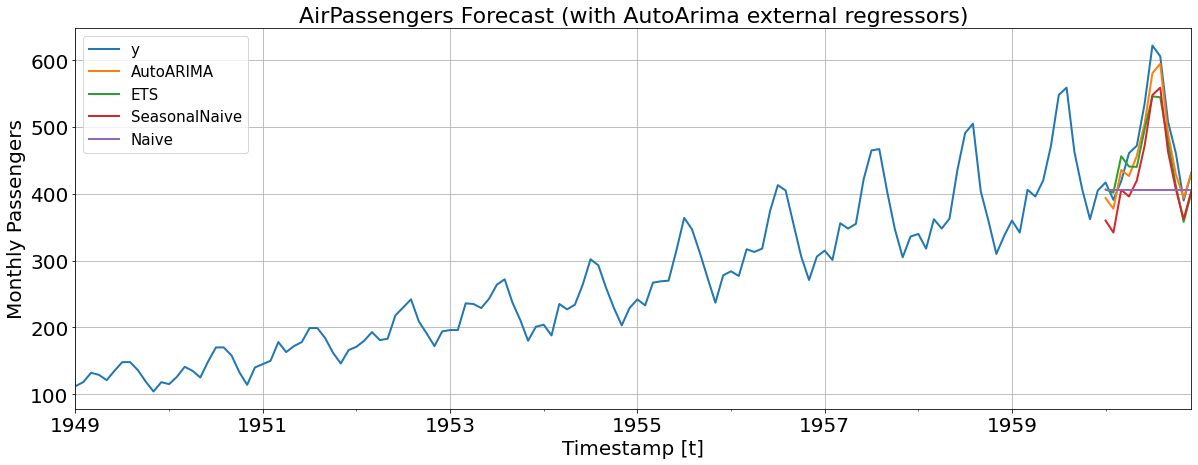

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df_bench = Y_test_df.merge(Y_hat_df_bench, how='left', on=['unique_id', 'ds'])
df_plot = pd.concat([Y_train_df, Y_hat_df_bench]).set_index('ds')
df_plot[['y', 'AutoARIMA', 'ETS', 'SeasonalNaive', 'Naive']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast (with AutoArima external regressors)', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/Getting_Started_with_Auto_Arima_and_ETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>